In [21]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, VARIABLES_PATTERN, K, N, P

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata2/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata2/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata2/variables=[0,2]


In [22]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.9438, 0.0927, 0.9387],
        [0.8450, 0.4752, 0.1635],
        [0.4614, 0.9441, 0.7453],
        [0.0268, 0.6350, 0.5561],
        [0.1837, 0.4824, 0.3946]])


In [23]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)


[   45    77   113 ... 99903 99940 99968]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


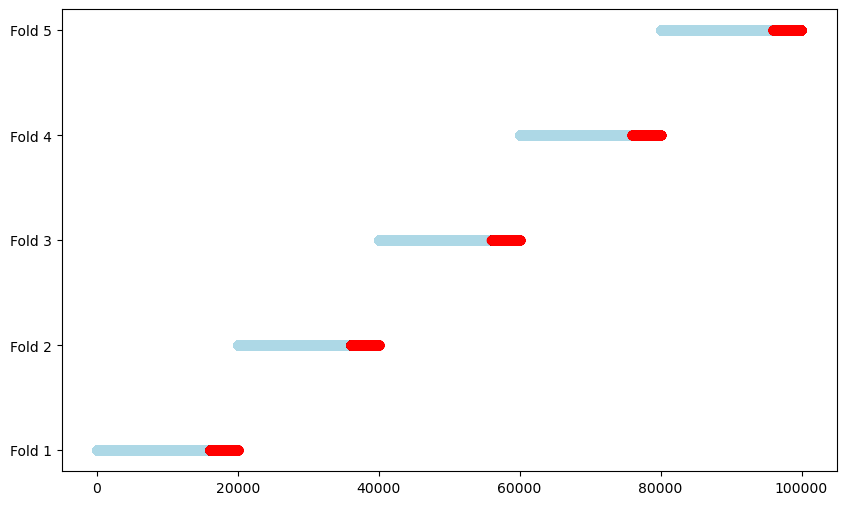

In [24]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [25]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, VARIABLES_PATTERN, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        X_mask[i, idx.item():idx.item()+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)

X_series shape: torch.Size([19974, 100, 2])
X_mask shape: torch.Size([19974, 100])
X_indices shape: torch.Size([19974, 4, 1])
y shape: torch.Size([19974, 1])


Number of finished trials:  100
Best trial: 71
Best hyperparameters: {'learning_rate': 0.0008912270705331527, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 16}
Validation Losses: [57.147, 59.233, 47.978, 50.871, 58.489]
Mean validation loss: 54.744
Test Losses: [60.126, 91.218, 61.993, 66.486, 76.04]
Mean test loss: 71.173
Mean test MAE: 6.052 std: 0.539
Mean test RMSE: 8.41 std: 0.66


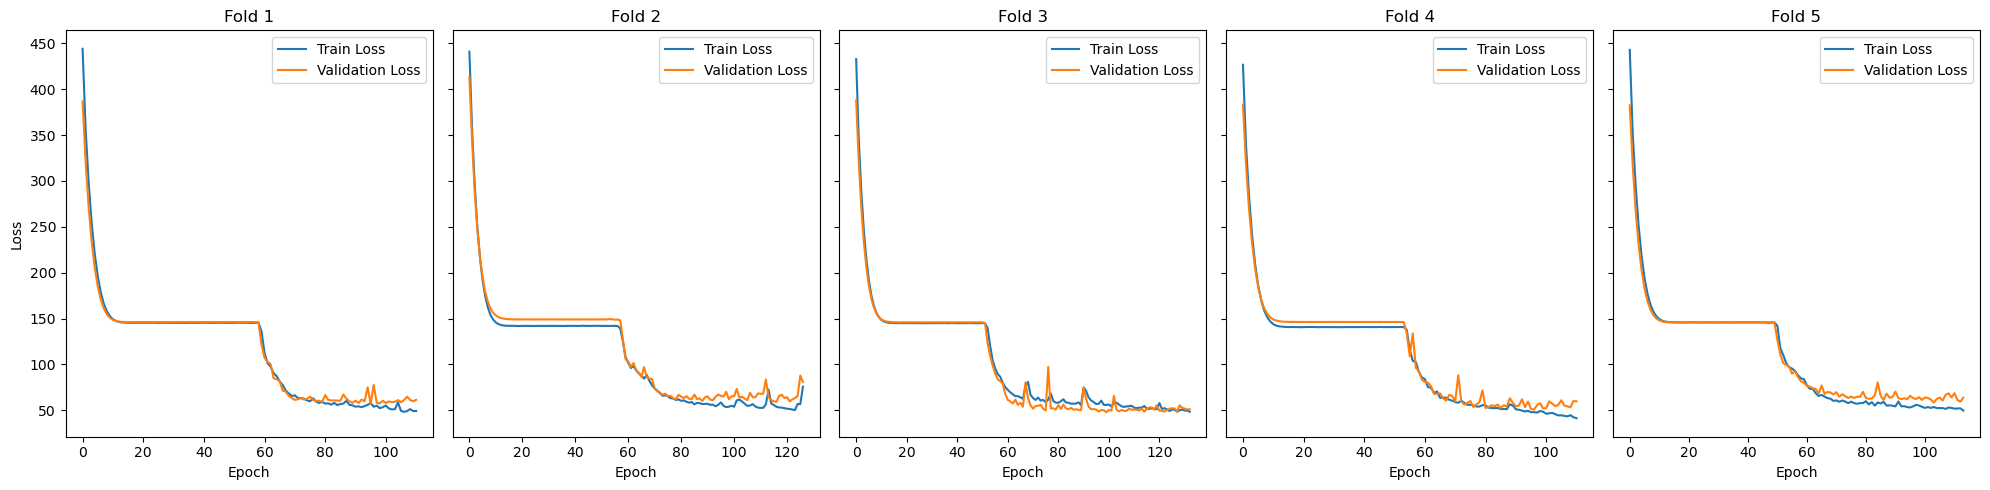

In [26]:
from models.lstm_pytorch import LSTM
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

#run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, [X_series], y, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


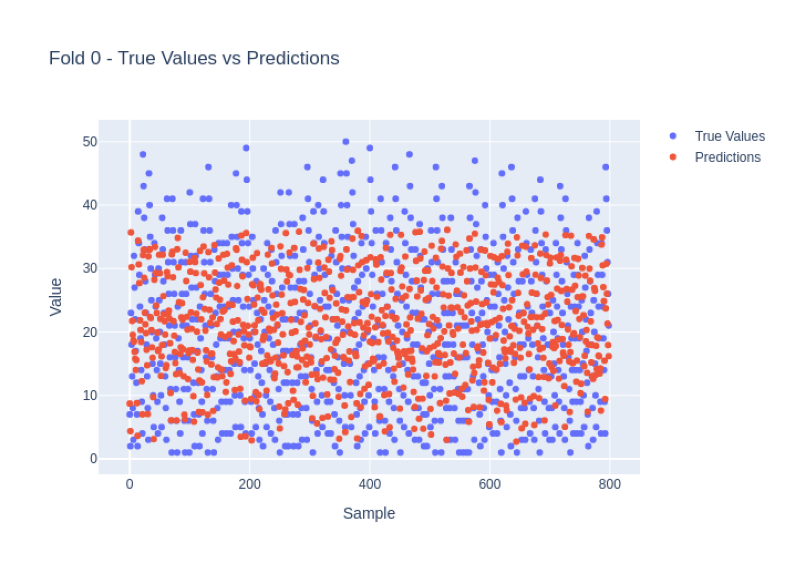

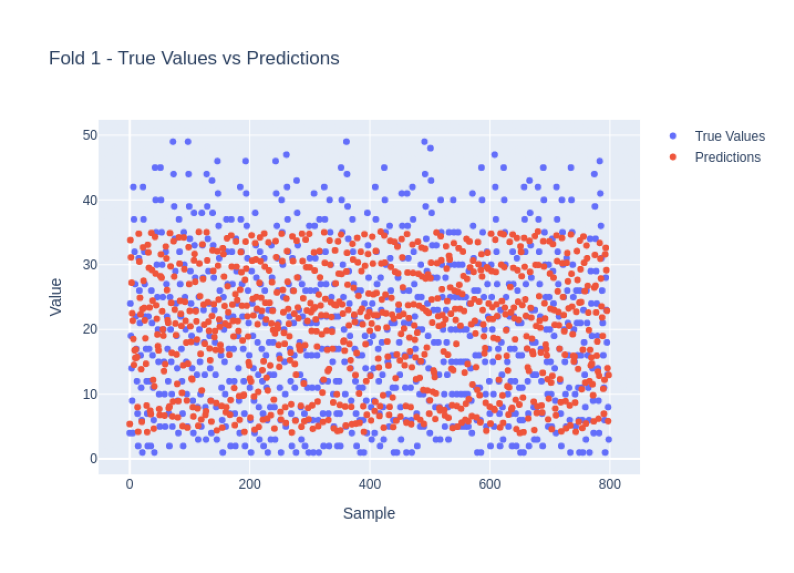

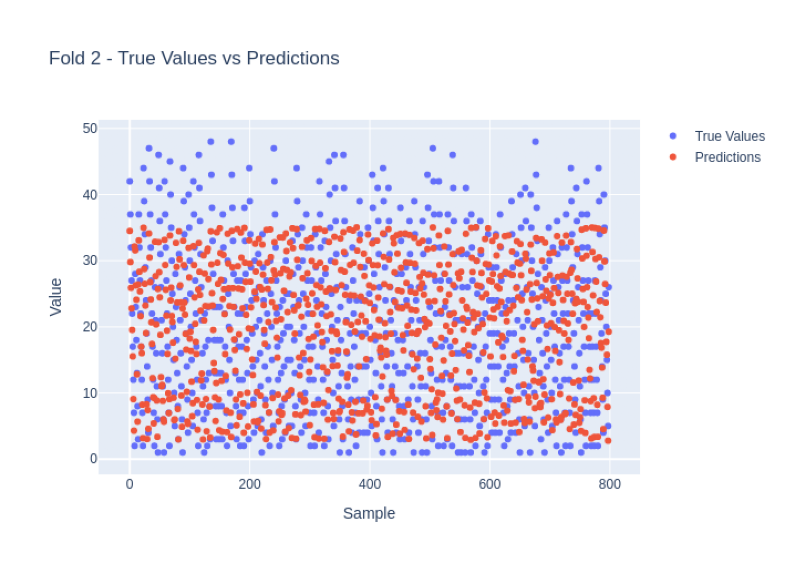

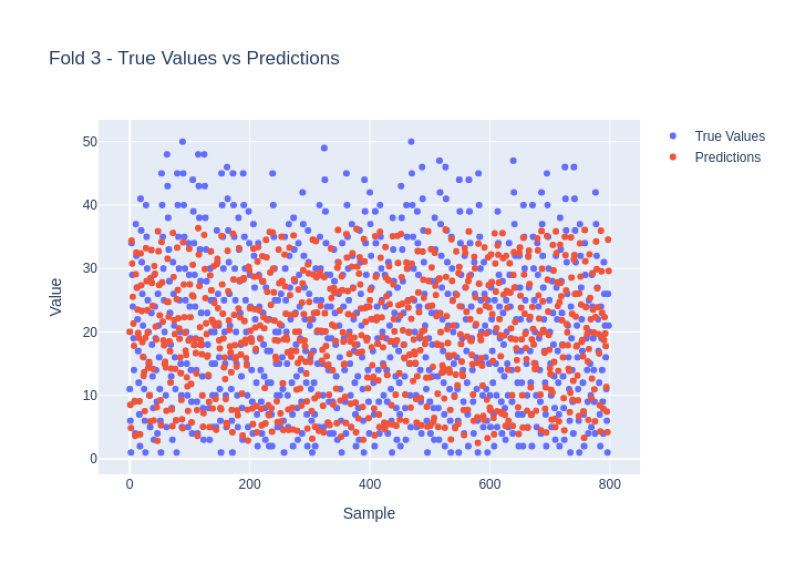

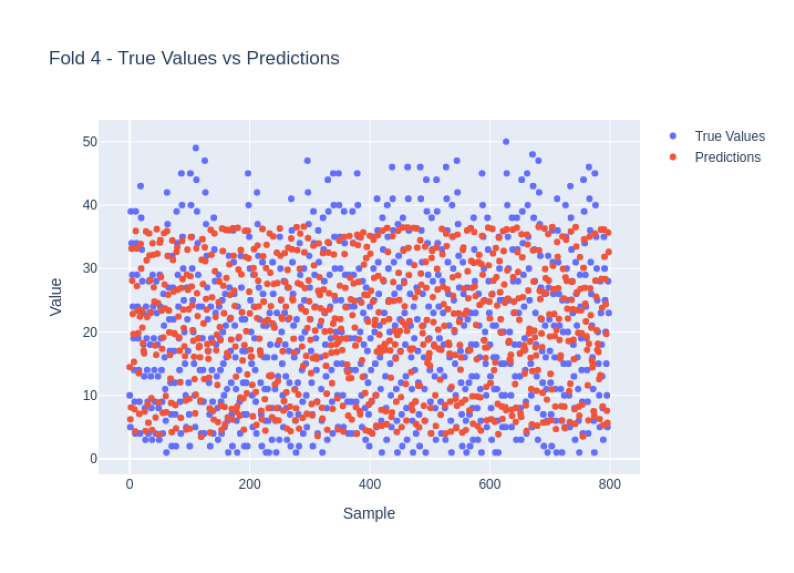

In [27]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X=[X_series], y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

for fold in range(5):
    img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()


In [18]:
from models.lstm_pytorch import LSTM

n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries_Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, [X_series, X_mask], y, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



[I 2024-12-27 12:32:10,129] A new study created in memory with name: no-name-6b4431cc-0fd8-4ddb-aed2-1d564c9d90ab


Early stopping at epoch 343, with best epoch being 331
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Early stopping at epoch 455, with best epoch being 444


[I 2024-12-27 12:41:31,935] Trial 0 finished with value: 120.06277923583984 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 32}. Best is trial 0 with value: 120.06277923583984.


Early stopping at epoch 355, with best epoch being 344
Training completed all epochs. Best epoch was 496
Training completed all epochs. Best epoch was 495
Training completed all epochs. Best epoch was 496
Early stopping at epoch 494, with best epoch being 483


[I 2024-12-27 12:44:57,627] Trial 1 finished with value: 96.36247863769532 and parameters: {'learning_rate': 1.793578709982463e-05, 'num_layers': 1, 'batch_size': 128, 'hidden_size_layer_0': 256}. Best is trial 1 with value: 96.36247863769532.


Early stopping at epoch 246, with best epoch being 235
Early stopping at epoch 272, with best epoch being 261
Early stopping at epoch 260, with best epoch being 249
Early stopping at epoch 313, with best epoch being 302
Early stopping at epoch 296, with best epoch being 285


[I 2024-12-27 12:47:12,832] Trial 2 finished with value: 68.23104248046874 and parameters: {'learning_rate': 7.653371871786874e-05, 'num_layers': 1, 'batch_size': 64, 'hidden_size_layer_0': 64}. Best is trial 2 with value: 68.23104248046874.


Early stopping at epoch 299, with best epoch being 288
Early stopping at epoch 112, with best epoch being 94
Early stopping at epoch 121, with best epoch being 110
Early stopping at epoch 123, with best epoch being 112
Early stopping at epoch 122, with best epoch being 111


[I 2024-12-27 12:55:46,839] Trial 3 finished with value: 52.970341491699216 and parameters: {'learning_rate': 0.00011338007139562508, 'num_layers': 3, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 256}. Best is trial 3 with value: 52.970341491699216.


Early stopping at epoch 117, with best epoch being 106
Early stopping at epoch 241, with best epoch being 230
Early stopping at epoch 201, with best epoch being 190
Early stopping at epoch 229, with best epoch being 218
Early stopping at epoch 111, with best epoch being 100


[I 2024-12-27 13:01:20,043] Trial 4 finished with value: 78.19502639770508 and parameters: {'learning_rate': 6.5652023505944e-05, 'num_layers': 3, 'batch_size': 64, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 256}. Best is trial 3 with value: 52.970341491699216.


Early stopping at epoch 202, with best epoch being 191
Early stopping at epoch 270, with best epoch being 259
Early stopping at epoch 350, with best epoch being 339
Early stopping at epoch 353, with best epoch being 342
Early stopping at epoch 334, with best epoch being 323


[I 2024-12-27 13:05:13,916] Trial 5 finished with value: 146.67366943359374 and parameters: {'learning_rate': 8.40991261739116e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 64}. Best is trial 3 with value: 52.970341491699216.


Early stopping at epoch 276, with best epoch being 265
Early stopping at epoch 124, with best epoch being 113
Early stopping at epoch 168, with best epoch being 157
Early stopping at epoch 161, with best epoch being 150
Early stopping at epoch 167, with best epoch being 156


[I 2024-12-27 13:08:23,423] Trial 6 finished with value: 146.67296142578124 and parameters: {'learning_rate': 4.413013947169429e-05, 'num_layers': 3, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 64}. Best is trial 3 with value: 52.970341491699216.


Early stopping at epoch 124, with best epoch being 113
Early stopping at epoch 117, with best epoch being 13
Early stopping at epoch 117, with best epoch being 106
Early stopping at epoch 114, with best epoch being 99
Early stopping at epoch 130, with best epoch being 119


[I 2024-12-27 13:10:04,541] Trial 7 finished with value: 110.49433898925781 and parameters: {'learning_rate': 0.0009678973008498044, 'num_layers': 3, 'batch_size': 64, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 64}. Best is trial 3 with value: 52.970341491699216.


Early stopping at epoch 183, with best epoch being 172
Training completed all epochs. Best epoch was 495
Early stopping at epoch 340, with best epoch being 329
Early stopping at epoch 420, with best epoch being 409
Early stopping at epoch 343, with best epoch being 332


[I 2024-12-27 13:15:42,489] Trial 8 finished with value: 61.361376190185545 and parameters: {'learning_rate': 0.0001030062884451417, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 16}. Best is trial 3 with value: 52.970341491699216.


Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 499


[I 2024-12-27 13:23:19,676] Trial 9 finished with value: 168.0832946777344 and parameters: {'learning_rate': 9.215336439857658e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 16}. Best is trial 3 with value: 52.970341491699216.


Training completed all epochs. Best epoch was 499
Early stopping at epoch 155, with best epoch being 144
Early stopping at epoch 114, with best epoch being 103
Early stopping at epoch 115, with best epoch being 104
Early stopping at epoch 138, with best epoch being 127


[I 2024-12-27 13:27:38,321] Trial 10 finished with value: 53.08212738037109 and parameters: {'learning_rate': 0.00024399596263150624, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32}. Best is trial 3 with value: 52.970341491699216.


Early stopping at epoch 138, with best epoch being 127
Early stopping at epoch 120, with best epoch being 109
Early stopping at epoch 125, with best epoch being 114
Early stopping at epoch 115, with best epoch being 104
Early stopping at epoch 115, with best epoch being 104


[I 2024-12-27 13:31:32,134] Trial 11 finished with value: 52.54073791503906 and parameters: {'learning_rate': 0.0003038924392575768, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32}. Best is trial 11 with value: 52.54073791503906.


Early stopping at epoch 132, with best epoch being 121
Early stopping at epoch 117, with best epoch being 106
Early stopping at epoch 113, with best epoch being 102
Early stopping at epoch 116, with best epoch being 105
Early stopping at epoch 129, with best epoch being 118


[I 2024-12-27 13:35:23,753] Trial 12 finished with value: 52.2366081237793 and parameters: {'learning_rate': 0.00032372868021400303, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32}. Best is trial 12 with value: 52.2366081237793.


Early stopping at epoch 113, with best epoch being 102
Early stopping at epoch 121, with best epoch being 110
Early stopping at epoch 113, with best epoch being 90
Early stopping at epoch 112, with best epoch being 101
Early stopping at epoch 119, with best epoch being 108


[I 2024-12-27 13:39:12,973] Trial 13 finished with value: 51.43871994018555 and parameters: {'learning_rate': 0.0004125186276747898, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32}. Best is trial 13 with value: 51.43871994018555.


Early stopping at epoch 123, with best epoch being 112
Early stopping at epoch 115, with best epoch being 96
Early stopping at epoch 126, with best epoch being 115
Early stopping at epoch 133, with best epoch being 122
Early stopping at epoch 116, with best epoch being 93


[I 2024-12-27 13:43:08,237] Trial 14 finished with value: 50.75990295410156 and parameters: {'learning_rate': 0.0006740800350958675, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 14 with value: 50.75990295410156.


Early stopping at epoch 115, with best epoch being 93
Early stopping at epoch 118, with best epoch being 64
Early stopping at epoch 116, with best epoch being 98
Early stopping at epoch 174, with best epoch being 163
Early stopping at epoch 126, with best epoch being 74


[I 2024-12-27 13:47:23,761] Trial 15 finished with value: 51.00529174804687 and parameters: {'learning_rate': 0.000856810073693655, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 14 with value: 50.75990295410156.


Early stopping at epoch 117, with best epoch being 97
Early stopping at epoch 115, with best epoch being 64
Early stopping at epoch 119, with best epoch being 108
Early stopping at epoch 132, with best epoch being 93
Early stopping at epoch 122, with best epoch being 73


[I 2024-12-27 13:51:55,378] Trial 16 finished with value: 50.71934051513672 and parameters: {'learning_rate': 0.0009482362298808263, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 16 with value: 50.71934051513672.


Early stopping at epoch 113, with best epoch being 99
Early stopping at epoch 114, with best epoch being 96
Early stopping at epoch 118, with best epoch being 94
Early stopping at epoch 124, with best epoch being 113
Early stopping at epoch 113, with best epoch being 91


[I 2024-12-27 13:55:40,355] Trial 17 finished with value: 51.907954406738284 and parameters: {'learning_rate': 0.0005371503601980826, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 16 with value: 50.71934051513672.


Early stopping at epoch 123, with best epoch being 112
Early stopping at epoch 113, with best epoch being 102
Early stopping at epoch 114, with best epoch being 103
Early stopping at epoch 179, with best epoch being 168
Early stopping at epoch 120, with best epoch being 109


[I 2024-12-27 13:59:44,632] Trial 18 finished with value: 52.44939193725586 and parameters: {'learning_rate': 0.00018699121244169402, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 64}. Best is trial 16 with value: 50.71934051513672.


Early stopping at epoch 112, with best epoch being 101
Early stopping at epoch 118, with best epoch being 107
Early stopping at epoch 120, with best epoch being 109
Early stopping at epoch 123, with best epoch being 112
Early stopping at epoch 114, with best epoch being 97


[I 2024-12-27 14:03:45,924] Trial 19 finished with value: 51.74733047485351 and parameters: {'learning_rate': 0.0005607320071555206, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 16 with value: 50.71934051513672.


Early stopping at epoch 135, with best epoch being 124
Early stopping at epoch 176, with best epoch being 165
Early stopping at epoch 191, with best epoch being 180
Early stopping at epoch 196, with best epoch being 185
Early stopping at epoch 196, with best epoch being 185


[I 2024-12-27 14:10:03,257] Trial 20 finished with value: 54.927268981933594 and parameters: {'learning_rate': 0.0001717656162442709, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 16}. Best is trial 16 with value: 50.71934051513672.


Early stopping at epoch 206, with best epoch being 195
Early stopping at epoch 113, with best epoch being 69
Early stopping at epoch 126, with best epoch being 115
Early stopping at epoch 111, with best epoch being 100
Early stopping at epoch 117, with best epoch being 81


[I 2024-12-27 14:13:57,809] Trial 21 finished with value: 50.683335876464845 and parameters: {'learning_rate': 0.0009266144387855399, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 21 with value: 50.683335876464845.


Early stopping at epoch 124, with best epoch being 87
Early stopping at epoch 114, with best epoch being 79
Early stopping at epoch 124, with best epoch being 113
Early stopping at epoch 122, with best epoch being 111
Early stopping at epoch 123, with best epoch being 84


[I 2024-12-27 14:17:55,783] Trial 22 finished with value: 50.66679916381836 and parameters: {'learning_rate': 0.0006219899083610201, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 22 with value: 50.66679916381836.


Early stopping at epoch 126, with best epoch being 115
Early stopping at epoch 112, with best epoch being 74
Early stopping at epoch 112, with best epoch being 80
Early stopping at epoch 114, with best epoch being 75
Early stopping at epoch 111, with best epoch being 68


[I 2024-12-27 14:21:42,852] Trial 23 finished with value: 51.313409423828126 and parameters: {'learning_rate': 0.0009755072285270084, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 16}. Best is trial 22 with value: 50.66679916381836.


Early stopping at epoch 128, with best epoch being 117
Early stopping at epoch 114, with best epoch being 103
Early stopping at epoch 115, with best epoch being 104
Early stopping at epoch 120, with best epoch being 109
Early stopping at epoch 122, with best epoch being 111


[I 2024-12-27 14:25:40,034] Trial 24 finished with value: 50.920755004882814 and parameters: {'learning_rate': 0.00043604913607229556, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 16}. Best is trial 22 with value: 50.66679916381836.


Early stopping at epoch 125, with best epoch being 114
Training completed all epochs. Best epoch was 495
Early stopping at epoch 238, with best epoch being 227


Best hyperparameters: {'learning_rate': 0.0008984307804662081, 'num_layers': 2, 'batch_size': 32, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 64}


Early stopping at epoch 120, with best epoch being 64
Early stopping at epoch 113, with best epoch being 63
Early stopping at epoch 114, with best epoch being 75
Early stopping at epoch 111, with best epoch being 68
Early stopping at epoch 115, with best epoch being 104
Validation Losses: [49.402801513671875, 58.46857833862305, 42.80439758300781, 47.88664627075195, 54.073638916015625]
Mean validation loss: 50.52721252441406
Test Losses: [58.06657791137695, 70.32230377197266, 56.107810974121094, 66.67920684814453, 66.20173645019531]
Mean test loss: 63.47552719116211


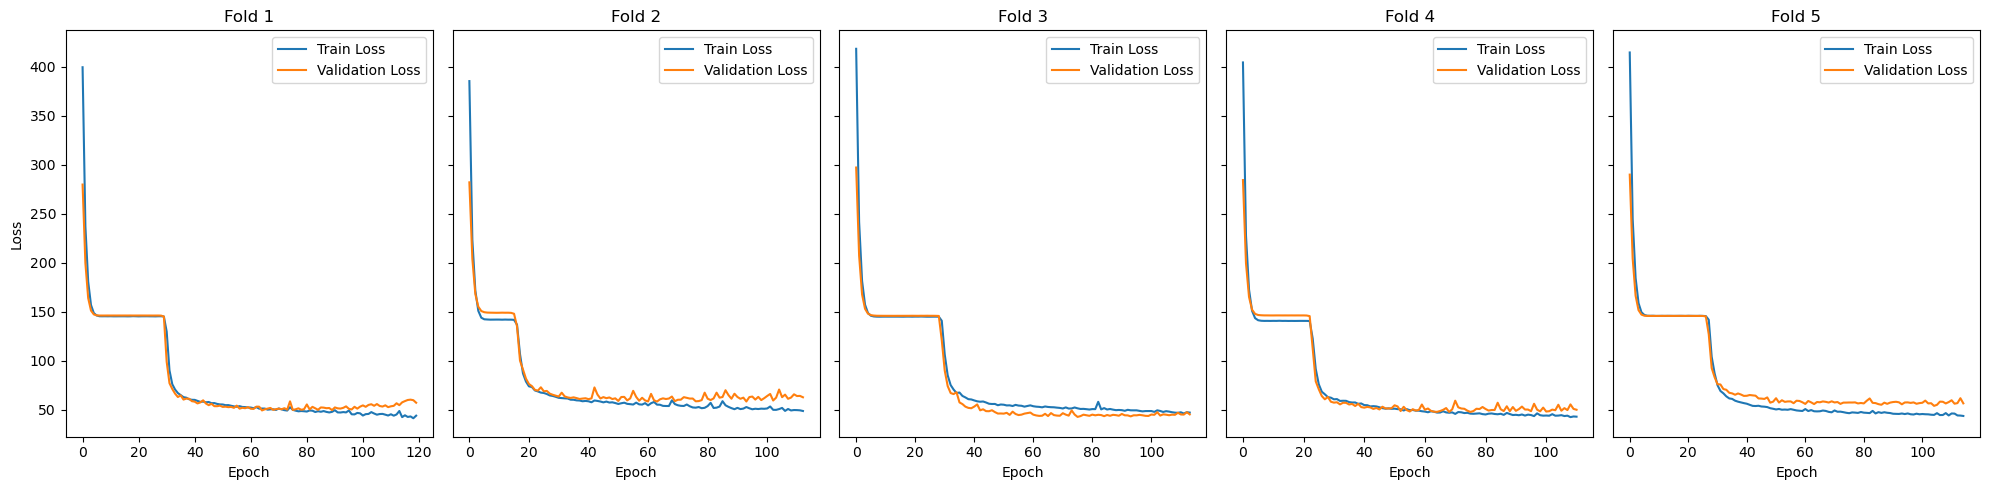

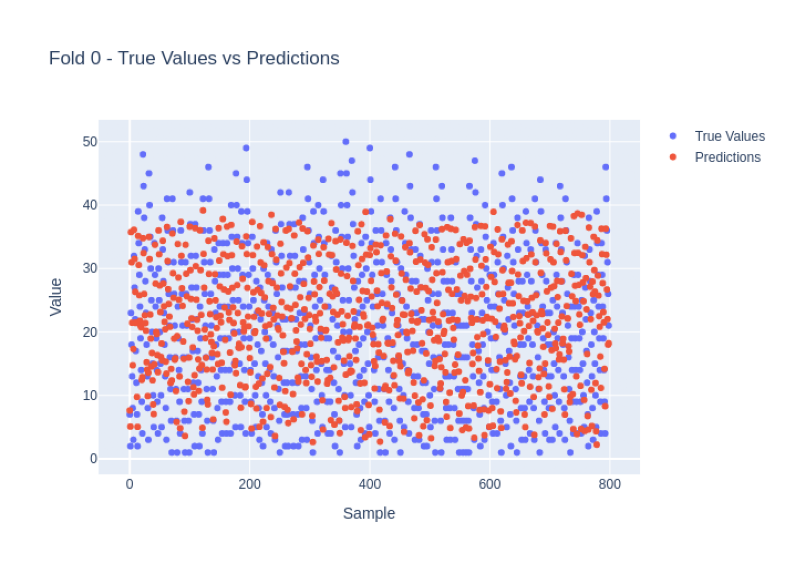

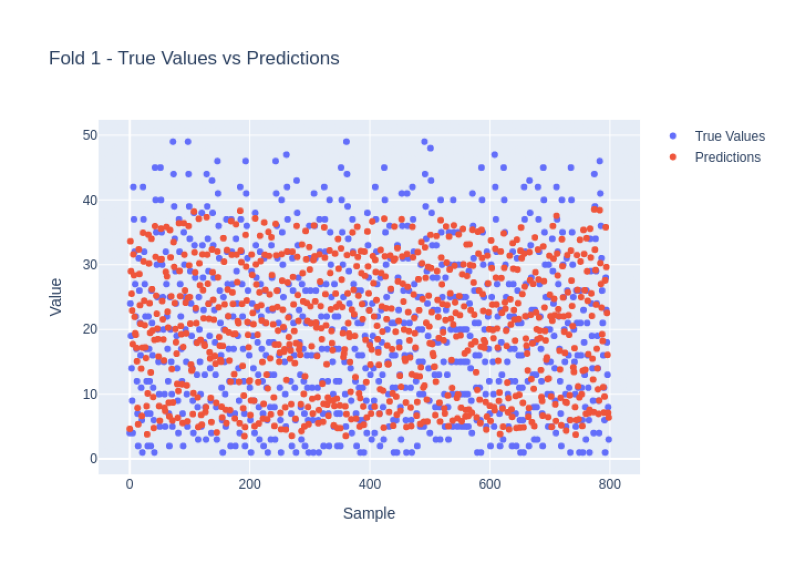

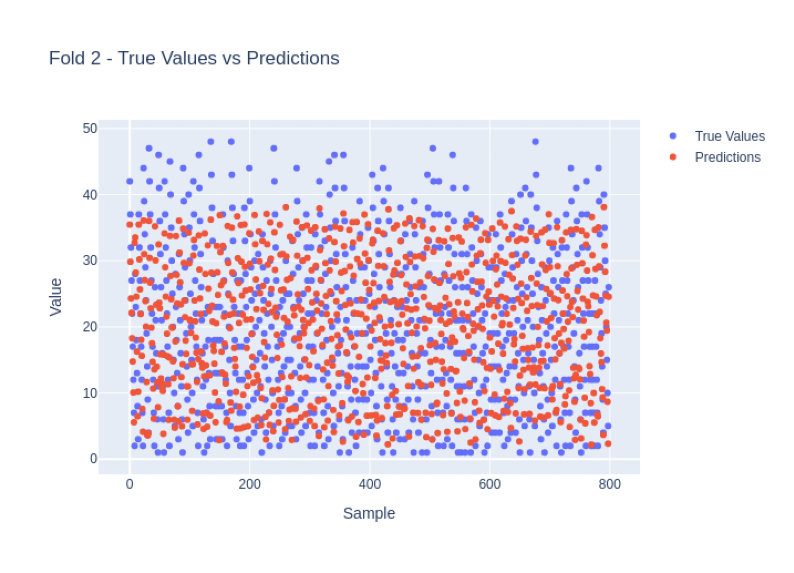

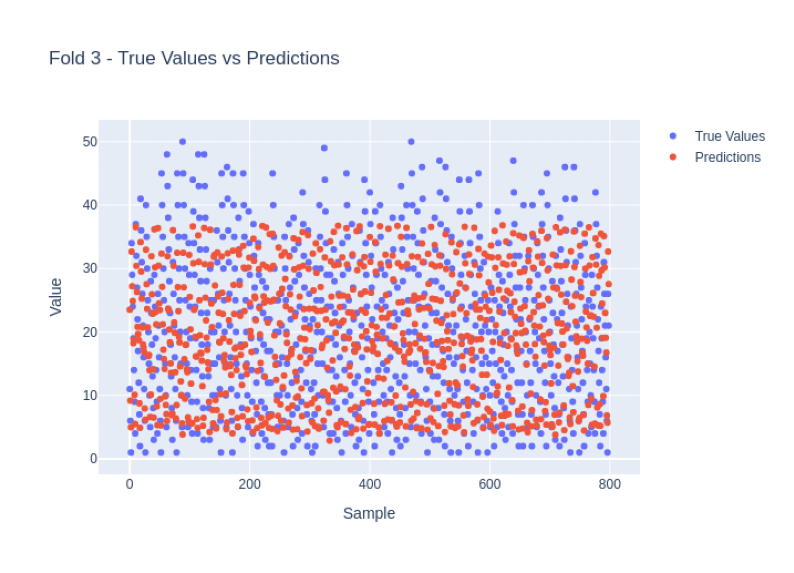

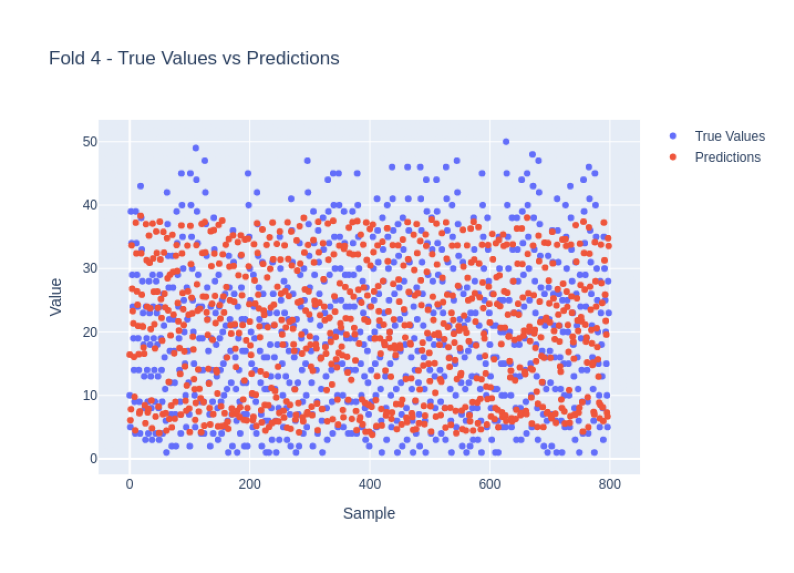

In [ ]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X=[X_series, X_mask], y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


Number of finished trials:  100
Best trial: 82
Best hyperparameters: {'learning_rate': 0.0006522522941668255, 'num_layers': 2, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 256}
Validation Losses: [45.765, 48.927, 40.828, 42.178, 51.204]
Mean validation loss: 45.78
Test Losses: [48.656, 54.29, 49.787, 52.552, 54.537]
Mean test loss: 51.965
Mean test MAE: 6.071 std: 0.199
Mean test RMSE: 7.207 std: 0.165


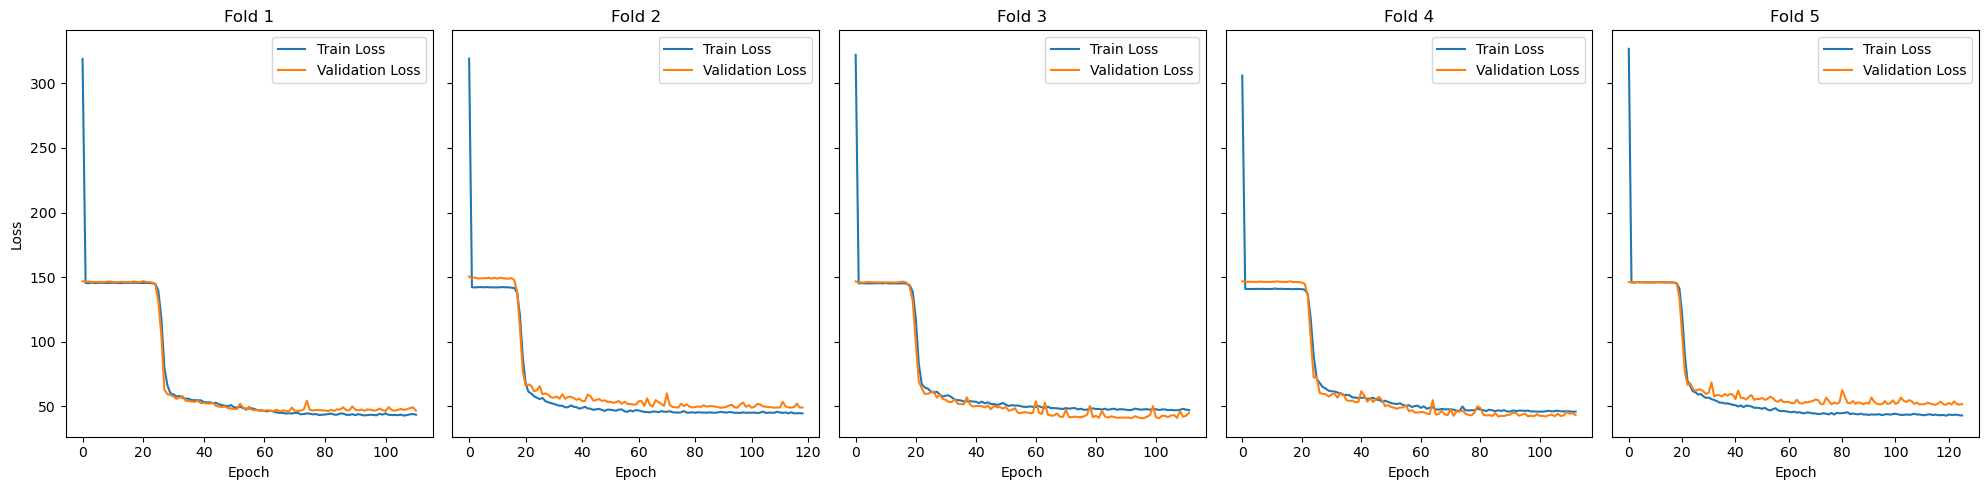

In [20]:
from models.lstm_pytorch import LSTM
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTM_Indexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

#run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, [X_indices], y, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


Best hyperparameters: {'learning_rate': 0.0006522522941668255, 'num_layers': 2, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 256}


Early stopping at epoch 111, with best epoch being 68
Early stopping at epoch 119, with best epoch being 89
Early stopping at epoch 112, with best epoch being 101
Early stopping at epoch 113, with best epoch being 86
Early stopping at epoch 126, with best epoch being 115
Validation Losses: [45.764892578125, 48.927215576171875, 40.827720642089844, 42.17838668823242, 51.20392608642578]
Mean validation loss: 45.78042831420898
Test Losses: [48.65633010864258, 54.28998565673828, 49.78744888305664, 52.55202865600586, 54.537109375]
Mean test loss: 51.96458053588867


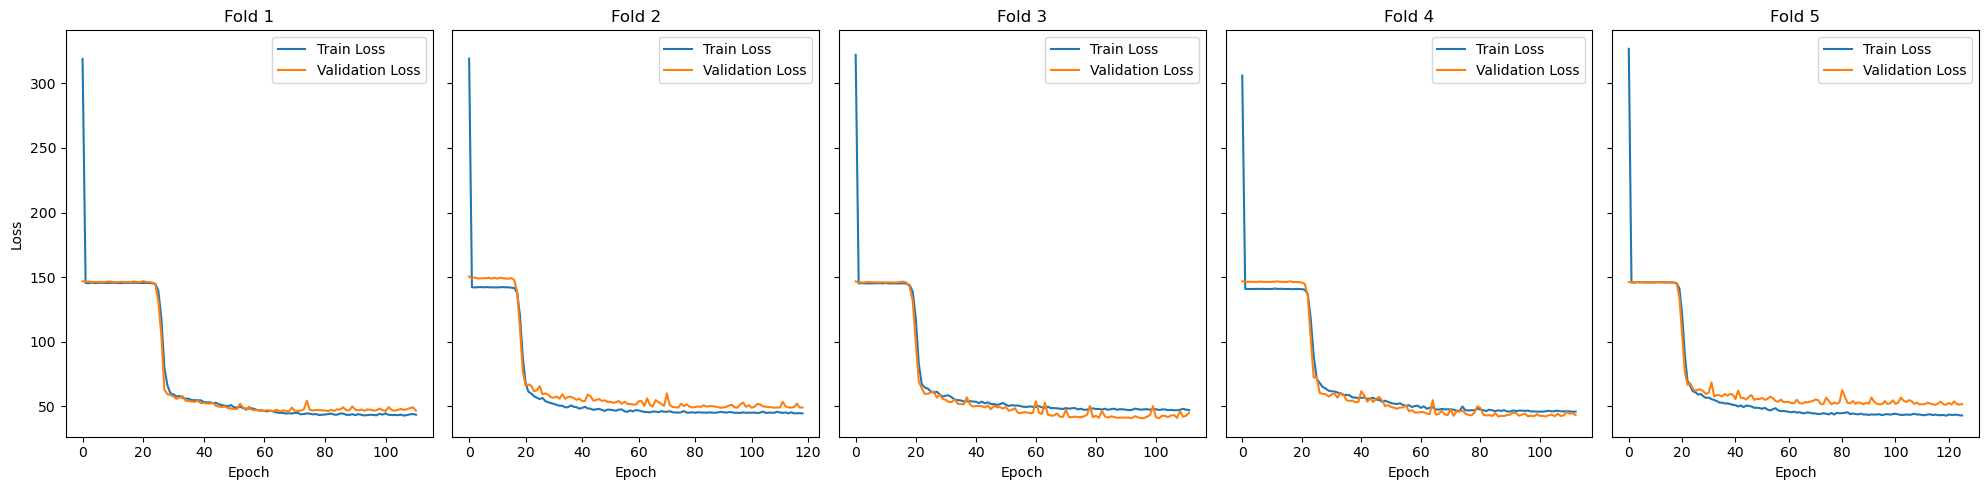

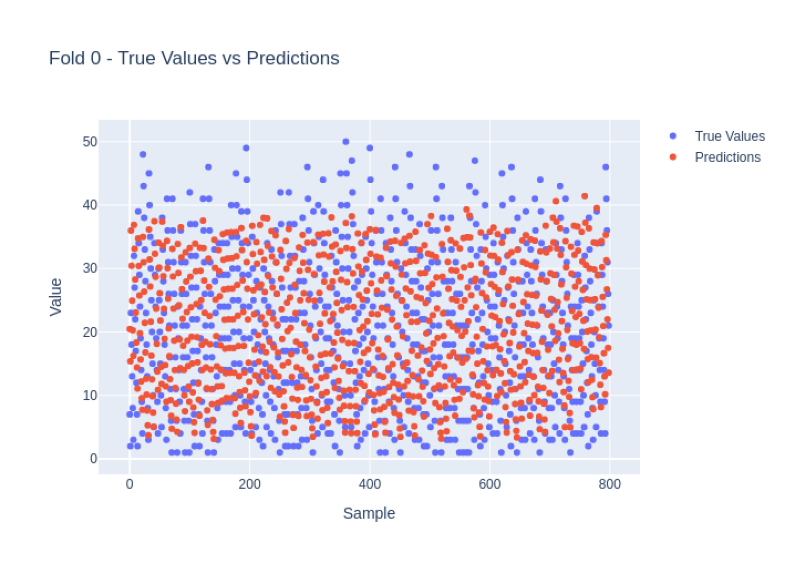

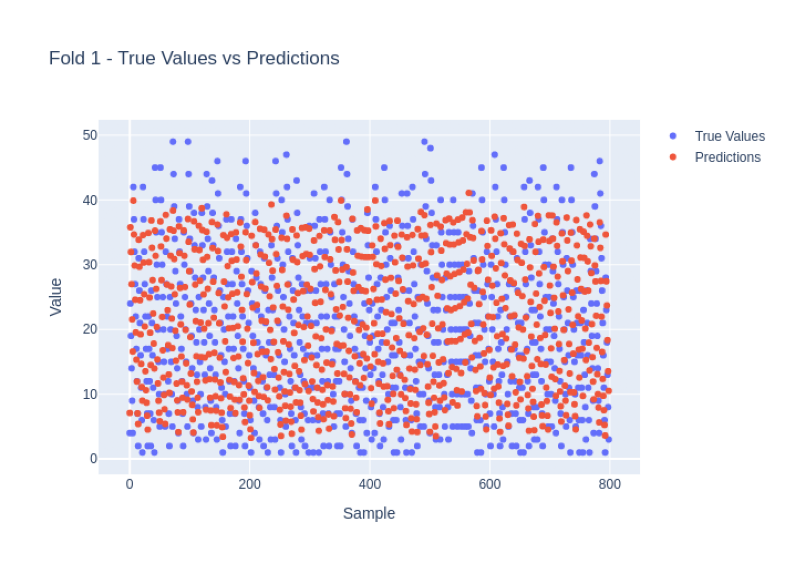

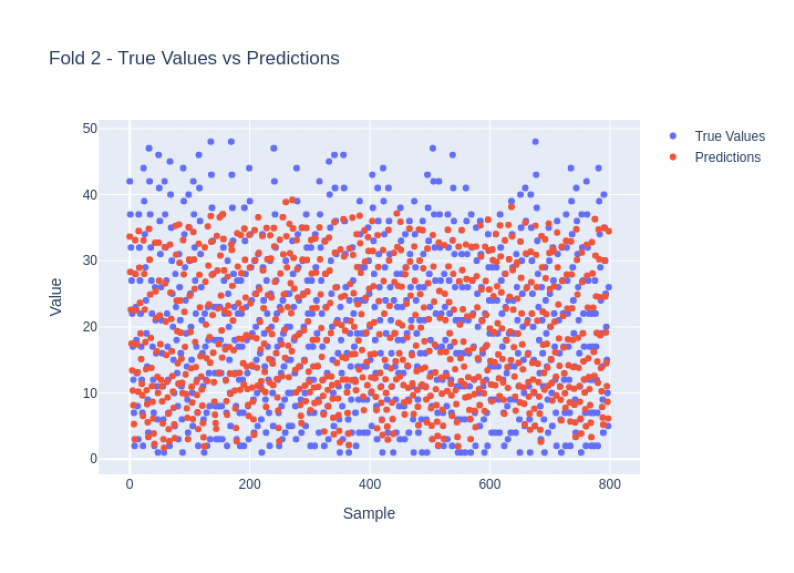

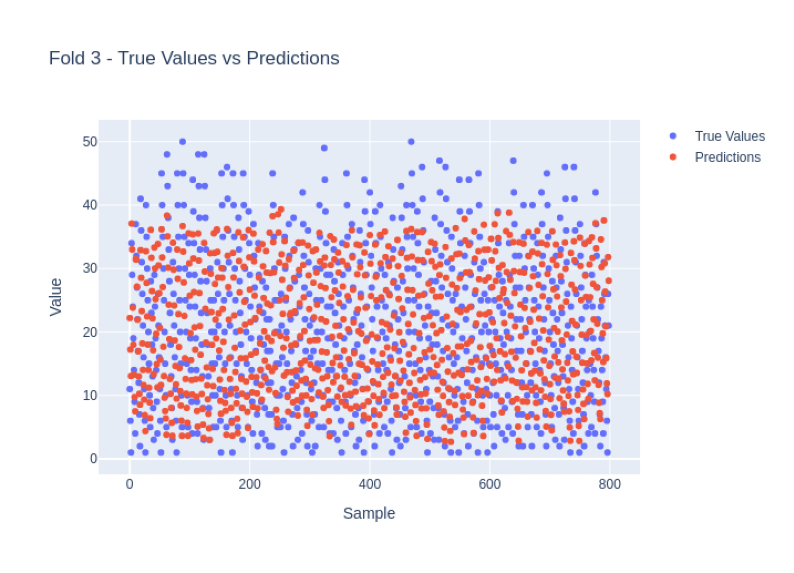

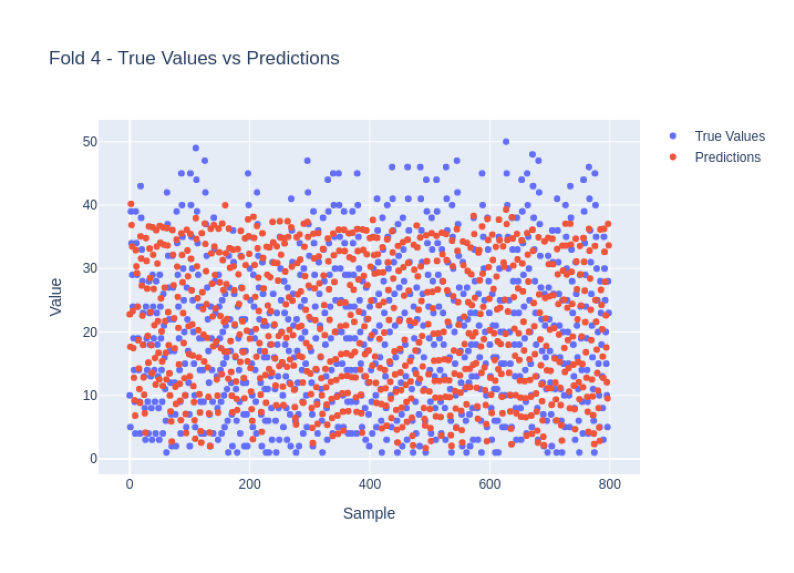

In [ ]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config

# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X=[X_indices], y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()